# Graphs and Mazes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import OrderedDict, deque, defaultdict, namedtuple
from itertools import product
from math import sqrt, pi, sin, cos
from random import random, randint, choice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from drawing import VectorImage

-----

# A) Number Maze

To say if there is a unique shortest solution, we use a modification of BFS that explores by whole layers of positions in the same depth instead of by a single position and for each postion, it remembers all its parents (on the shortest path from the start). If any position on a shortest path between the start and the goal has multiple parents, then tha solution is not unique. *(I wonder if there is a simpler approach.)*

In [75]:
def solve_number_maze(maze, print_results=True):
    maze = np.matrix(maze)
    dirs = list(map(np.array, [(1, 0), (0, 1), (-1, 0), (0, -1)]))
    start = (0, 0)
    goal = (maze.shape[0] - 1, maze.shape[1] - 1)
    # As we process whole layers, we can use list to store the queue.
    queue = [start]
    # For each position we store all of its parents on a shortes path.
    parents = defaultdict(list)
    parents[start] = [None]
    solution = None
    while queue and not solution:
        next_layer = []
        # Freeze previously seen positions.
        seen = set(parents.keys())
        for pos in queue:
            for direction in dirs:
                next_pos = get_next_pos(maze, pos, direction)
                if not next_pos or next_pos in seen:
                    continue
                next_layer.append(next_pos)
                parents[next_pos].append(pos)
        if goal in next_layer:
            solution, unique = get_path(goal, parents, ret_unique=True)
        queue = next_layer
    if print_results:
        print('Solution:', solution)
        print('Unique:', unique)
    else:
        return solution, unique

def get_next_pos(maze, pos, direction):
    length = maze[pos]
    next_pos = length * direction + pos
    if any(next_pos < (0, 0)) or any(next_pos >= maze.shape):
        return None  # out of the maze
    return tuple(next_pos)

def get_path(pos, parents, ret_unique=False):
    backpath = []
    unique = True
    while pos:
        backpath.append(pos)
        unique = unique and len(parents[pos]) == 1
        pos = parents[pos][0]
    path = list(reversed(backpath))
    return path, unique if ret_unique else path

solve_number_maze(
    [[2, 4, 4, 3, 3],
     [2, 3, 3, 2, 3],
     [3, 2, 3, 1, 3],
     [2, 2, 3, 2, 1],
     [1, 4, 4, 4, 0]])

Solution: [(0, 0), (2, 0), (2, 3), (1, 3), (1, 1), (1, 4), (4, 4)]
Unique: True


In [79]:
solve_number_maze([[1, 1], [1, 0]])

Solution: [(0, 0), (1, 0), (1, 1)]
Unique: False


In [77]:
solve_number_maze(
    [[3, 4, 3, 2, 2],
     [4, 4, 2, 2, 4],
     [4, 3, 1, 4, 2],
     [2, 1, 1, 3, 3],
     [1, 4, 2, 3, 0]])

Solution: [(0, 0), (3, 0), (3, 2), (4, 2), (4, 4)]
Unique: True


In [78]:
solve_number_maze(
    [[1, 4, 2, 1, 1],
     [2, 4, 2, 3, 2],
     [2, 3, 4, 2, 4],
     [3, 3, 3, 3, 2],
     [2, 4, 2, 2, 0]])

Solution: [(0, 0), (1, 0), (3, 0), (3, 3), (0, 3), (1, 3), (4, 3), (2, 3), (2, 1), (2, 4), (2, 0), (4, 0), (4, 2), (4, 4)]
Unique: True


To check if my BFS implementation (uniqueness decision) is correct, I compared the results a brute force solution to the problem:

In [86]:
def brute_force_number_maze(maze):
    maze = np.matrix(maze)
    dirs = list(map(np.array, [(1, 0), (0, 1), (-1, 0), (0, -1)]))
    goal = (maze.shape[0] - 1, maze.shape[1] - 1)
    solutions = []
    for length in range(1, maze.shape[0] * maze.shape[1]):
        for path_dirs in product(dirs, repeat=length):
            path = create_path(maze, path_dirs)
            if path and path[-1] == goal:
                solutions.append(path)
        if solutions:
            return solutions

def create_path(maze, dirs):
    path = [(0, 0)]
    for direction in dirs:
        next_pos = get_next_pos(maze, path[-1], direction)
        if not next_pos:
            return None
        path.append(next_pos)
    return path
                
brute_force_number_maze(
    [[3, 4, 3, 2, 2],
     [4, 4, 2, 2, 4],
     [4, 3, 1, 4, 2],
     [2, 1, 1, 3, 3],
     [1, 4, 2, 3, 0]])

[[(0, 0), (3, 0), (3, 2), (4, 2), (4, 4)]]

## B: Quantum Maze

Goal: get from the bottom-left to the top-right corner.

Representation of states: current position, set of walls.

TODO: visualizations (see bellow)

Visualizations:
- static (final maze + path)
- static + time as the darkness/alpha
- widget to go through time
- animation in time for export

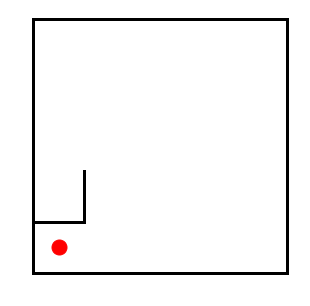

In [17]:
def draw_state(state, im=None, linewidth=3):
    im = im or VectorImage()
    n = state.size
    corners = [(0, 0), (0, n), (n, n), (n, 0)]
    for i in range(4):
        im.line(corners[i], corners[(i+1)%4], linewidth=linewidth)
    im.lines(state.walls, linewidth=linewidth)
    real_pos = np.array([0.5, 0.5]) + state.pos
    im.point(real_pos, color='r', markersize=15)


State = namedtuple('State', ['pos', 'walls', 'size'])
state = State(pos=(0, 0), size=5,
              walls={((0, 1), (1, 1)), ((1, 1), (1, 2))})
draw_state(state)

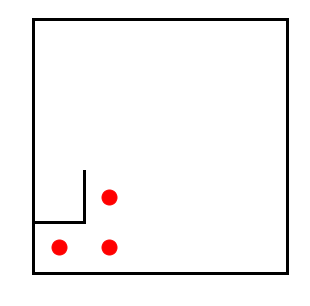

In [18]:
def draw_solution(states, im=None, linewidth=3):
    im = im or VectorImage()
    for state in states:
        draw_state(state, im=im)

s1 = State(pos=(0,0), size=5, walls={})
s2 = State(pos=(1,0), size=5, walls={((0,1), (1,1))})
s3 = State(pos=(1,1), size=5, walls={((0,1), (1,1)), ((1,1), (1,2))})
draw_solution([s1, s2, s3])

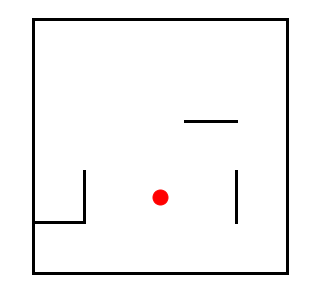

In [92]:
def create_next_state(state, direction):
    # Set main and orthogonal (left and right) directions
    d = np.array(direction)
    dl = np.array([-direction[1], direction[0]])
    dr = -dl
    pos = tuple(d + state.pos)
    # Real position is shifted:
    p = np.array([0.5, 0.5]) + pos
    walls = set(state.walls)
    crossed_edge = normalize((p - 0.5*d + 0.5*dl, p - 0.5*d + 0.5*dr))
    if crossed_edge in walls:
        return None
    # Add new walls:
    front_wall = (p + 1.5*d + 0.5*dl, p + 1.5*d + 0.5*dr)
    left_wall = (p + 0.5*d + 1.5*dl, p + 1.5*d + 1.5*dl)
    right_wall = (p + 0.5*d + 1.5*dr, p + 1.5*d + 1.5*dr)
    # Filter walls outside the maze (and normalize them).
    new_walls = [
        normalize(wall)
        for wall in [front_wall, left_wall, right_wall]
        if is_wall_in_maze(wall, state.size)]    
    walls.update(new_walls)        
    next_state = State(
        pos=pos, walls=tuple(sorted(walls)), size=state.size)
    return next_state

def normalize(wall):
    return tuple(sorted((int(x), int(y)) for x, y in wall))

def is_wall_in_maze(wall, size):
    coords = [n for point in wall for n in point]
    return min(coords) >= 0 and max(coords) <= size

draw_state(create_next_state(s3, (1, 0)))

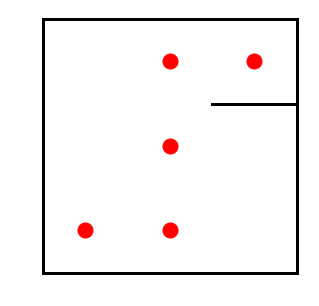

In [95]:
def solve_quantum_maze(size=3, max_steps=10000):
    dirs = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    # Add borders to initial set of edges:
    walls = set()
    for i in range(size):
        walls.add(((0, i), (0, i+1)))
        walls.add(((size, i), (size, i+1)))
        walls.add(((i, 0), (i+1, 0)))
        walls.add(((i, size), (i+1, size)))
    start = State(pos=(0,0), walls=tuple(sorted(walls)), size=size)
    goal = (size - 1, size - 1)
    queue = deque([start])
    parents = {}
    parents[start] = None
    for i_step in range(max_steps):
        if not queue:
            print('No solution exists.')
            return
        next_layer = []
        state = queue.popleft()
        if state.pos == goal:
            return get_path(state, parents)
        for direction in dirs:
            next_state = create_next_state(state, direction)
            if not next_state or next_state in parents:
                continue
            queue.append(next_state)
            parents[next_state] = state
    print('Step limit exceeded.')
    
def get_path(state, parents):
    backpath = []
    while state:
        backpath.append(state)
        state = parents[state]
    return list(reversed(backpath))

draw_solution(solve_quantum_maze(size=3))

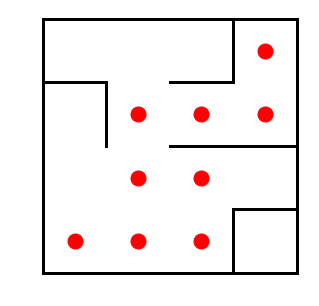

In [96]:
draw_solution(solve_quantum_maze(size=4))